In [1]:
from Bruce import Tools

   0_1  0_a  1_3  1_b  2_4  2_c
0    1    0    1    0    1    0
1    0    1    0    1    0    1


In [2]:
from Bruce.Tools import readTrainData, readTestData, category2num1, \
    category2num2, category2num3, category2num4, category2num5, numericStandard, valuation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import xgboost as xgb
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, Lasso
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

/Users/brucepei/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## 1 Loading data


 mu = 180921.20 and sigma = 79415.29



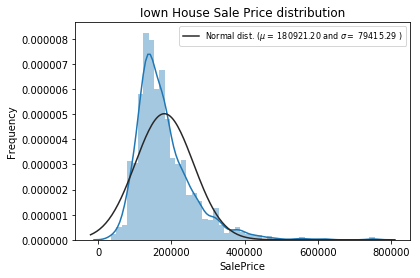

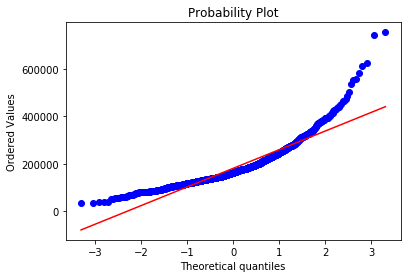

Skewness: 1.882876
Kurtosis: 6.536282


In [3]:
train_data = readTrainData()
test_data = readTestData()
train_data1 = readTrainData()
test_data1 = readTestData()
# SalePrice histogram
# Plot Histogram
sns.distplot(train_data['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='upper right',prop={'size': 8})
plt.ylabel('Frequency')
plt.title('Iown House Sale Price distribution')
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)
plt.show()

print("Skewness: %f" % train_data['SalePrice'].skew())
print("Kurtosis: %f" % train_data['SalePrice'].kurt())

In [4]:
# check if any SalePrice in train data is na
train_labels = np.log(train_data['SalePrice'])
#train_data.drop('SalePrice', axis=1, inplace=True)
print(train_labels.describe())

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64


##### This is not quite look like a normal distribution. 
##### The kurtosis score has a very nice peak. 
 So we need to fix this for sure!

In [5]:
# check whether each column contains na
train_isnull = train_data.isnull().sum()
#train_isnull=train_isnull.sort_values(inplace=True)
print(train_isnull[train_isnull > 0])

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [6]:
test_isnull = test_data.isnull().sum()
# print(type(train_isnull))    Series
print(test_isnull[test_isnull > 0])

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64


In [7]:
# drop columns with >50% missing values
# therefore, drop "Id", "Alley", "PoolQC", "Fence" & "MiscFeature"
features_toBeAbandoned = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
train_data.drop(features_toBeAbandoned, axis=1, inplace=True)
test_data.drop(features_toBeAbandoned, axis=1, inplace=True)

# 2 fill in missing values

In [8]:
# 1 fill "LotFrontage" data with median
train_data['LotFrontage'] = train_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
test_data['LotFrontage'] = test_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [9]:
train_data['Electrical'] = train_data['Electrical'].fillna(train_data['Electrical'].mode()[0])

In [10]:
train_whetherNull = train_data.isnull().sum()
train_whetherNull[train_whetherNull>0]
# type(train_whetherNull) Series
train_isnull = train_whetherNull[train_whetherNull > 0]
# print(type(train_isnull))    Series
for idx in train_isnull.index:
    # print(idx)
    # print(type(train_data[idx]))
    # print(type(train_data[idx][0]))
    if(isinstance(train_data[idx][1], str)):
        train_data[idx] = train_data[idx].fillna('None')
    else:
        train_data[idx] = train_data[idx].fillna(0)

In [11]:
test_whetherNull = test_data.isnull().sum()
test_isnull = test_whetherNull[test_whetherNull > 0]
# print(type(train_isnull))    Series
for idx in test_isnull.index:
    if(isinstance(train_data[idx][2], str)):
        test_data[idx] = test_data[idx].fillna('None')
    else:
        test_data[idx] = test_data[idx].fillna(0)

In [12]:
# Check if there still any missing data
train_isnull2 = train_data.isnull().sum()
# print(type(train_isnull))    Series
print(train_isnull2[train_isnull2 > 0])
test_isnull2 = test_data.isnull().sum()
# print(type(train_isnull))    Series
print(test_isnull2[test_isnull2 > 0])
print("no missing columns.....")

Series([], dtype: int64)
Series([], dtype: int64)
no missing columns.....


In [13]:
# MasVnrType is the same as MasVnrArea
train_data['MasVnrType'] = train_data['MasVnrType'].fillna('None')
train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(0)
test_data['MasVnrType'] = test_data['MasVnrType'].fillna('None')
test_data['MasVnrArea'] = test_data['MasVnrArea'].fillna(0)

In [14]:
# fill 
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    train_data[col] = train_data[col].fillna('None')
    test_data[col] = test_data[col].fillna('None')
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    test_data[col] = test_data[col].fillna(0)

In [15]:
train_isnull2 = train_data.isnull().sum()
# print(type(train_isnull))    Series
print(train_isnull2[train_isnull2 > 0])
test_isnull2 = test_data.isnull().sum()
# print(type(train_isnull))    Series
print(test_isnull2[test_isnull2 > 0])

Series([], dtype: int64)
Series([], dtype: int64)


## 3 start working on features now

In [16]:
print("train_data size is : {}".format(train_data.shape))
print("test_data size is : {}".format(test_data.shape))
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
all_data = pd.concat((train_data, test_data)).reset_index(drop=True)
print("all_data size is : {}".format(all_data.shape))

train_data size is : (1460, 77)
test_data size is : (1459, 77)
all_data size is : (2919, 77)


# check the top 10 features for Sale Price & Remove outliers 

In [17]:
for col in ['MSSubClass', 'MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope',
            'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',
            'Exterior2nd','MasVnrType','Foundation','Heating','Electrical','Functional','GarageType','PavedDrive',
            'SaleType','SaleCondition']:
    train_data[col] = pd.get_dummies(all_data[col])

In [18]:
# numeric standard for numeric values
for col in ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
            '2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
            'ScreenPorch','PoolArea']:
    train_data[col] = numericStandard(all_data[col])

In [19]:
train_data["SalePrice"]=train_data1["SalePrice"]

In [20]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,0,0,-0.210631,-0.217841,0,0,0,1,0,...,-0.359539,-0.103313,-0.285886,-0.063139,0,2,2008,0,0,208500
1,2,1,0,0.479571,-0.072032,0,0,0,1,0,...,-0.359539,-0.103313,-0.285886,-0.063139,0,5,2007,0,0,181500
2,3,0,0,-0.072591,0.137173,0,1,0,1,0,...,-0.359539,-0.103313,-0.285886,-0.063139,0,9,2008,0,0,223500
3,4,0,0,-0.440699,-0.078371,0,1,0,1,1,...,3.874303,-0.103313,-0.285886,-0.063139,0,2,2006,0,1,140000
4,5,0,0,0.663626,0.518814,0,1,0,1,0,...,-0.359539,-0.103313,-0.285886,-0.063139,0,12,2008,0,0,250000


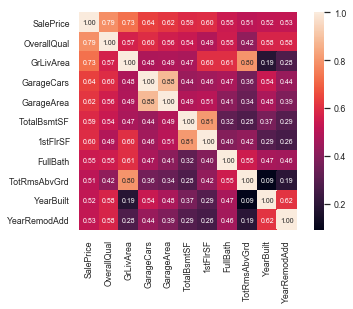

In [24]:
#### clustering is used here!
# Top 10 Heatmap
corrmat = train_data.corr()
k = 11 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=.8)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 7}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [25]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,SalePrice
1,OverallQual
2,GrLivArea
3,GarageCars
4,GarageArea
5,TotalBsmtSF
6,1stFlrSF
7,FullBath
8,TotRmsAbvGrd
9,YearBuilt


# Then check the relationship between each feature and the sale price.

# 1 Overall Quality

In [ ]:
# Overall Quality vs Sale Price
var = 'OverallQual'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

In [ ]:
# Living Area vs Sale Price
g=sns.jointplot(x=train_data["GrLivArea"], y=train_data["SalePrice"], kind = "reg")
g.annotate(stats.pearsonr)
plt.show()

In [ ]:
# Removing outliers manually (Two points in the bottom right)
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4) 
                         & (train_data['SalePrice']<300000)].index).reset_index(drop=True)

In [ ]:
# Living Area vs Sale Price
Gr=sns.jointplot(x=train_data['GrLivArea'], y=train_data['SalePrice'], kind='reg')
Gr.annotate(stats.pearsonr)
plt.show()

In [ ]:
# Garage Area vs Sale Price
sns.boxplot(x=train_data['GarageCars'], y=train_data['SalePrice'])
plt.show()

In [ ]:
# Removing outliers manually (More than 4-cars, less than $300k)
train = train_data.drop(train_data[(train_data['GarageCars']>3) 
                         & (train_data['SalePrice']<300000)].index).reset_index(drop=True)

In [ ]:
# Garage Area vs Sale Price
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

In [ ]:
# Garage Area vs Sale Price
Ga=sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')
Ga.annotate(stats.pearsonr)
plt.show()

In [ ]:
# Removing outliers manually (More than 1000 sqft, less than $300k)
train = train.drop(train[(train['GarageArea']>1000) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

In [ ]:
# Removing outliers manually (More than 750 sqft, more than $700k)
train = train.drop(train[(train['GarageArea']>750) 
                         & (train['SalePrice']>700000)].index).reset_index(drop=True)

In [ ]:
# Garage Area vs Sale Price
Ga=sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')
Ga.annotate(stats.pearsonr)
plt.show()

In [ ]:
# Basement Area vs Sale Price
B=sns.jointplot(x=train['TotalBsmtSF'], y=train['SalePrice'], kind='reg')
B.annotate(stats.pearsonr)
plt.show()

In [ ]:
# First Floor Area vs Sale Price
F=sns.jointplot(x=train['1stFlrSF'], y=train['SalePrice'], kind='reg')
F.annotate(stats.pearsonr)
plt.show()

In [ ]:
# Total Rooms vs Sale Price
sns.boxplot(x=train['TotRmsAbvGrd'], y=train['SalePrice'])

In [ ]:
# Year Built vs Sale Price
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=700000);
plt.xticks(rotation=90);

In [ ]:
# Year Remod Add vs Sale Price
var = 'YearRemodAdd'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=700000);
plt.xticks(rotation=90);

In [ ]:
train_data.drop('SalePrice', axis=1, inplace=True)

#### Transfer all other types as categorical type

In [ ]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
# test_data['MSSubClass'] = test_data['MSSubClass'].astype(str)
# ExterQual ExterCond
all_data['ExterQual'] = category2num1(all_data['ExterQual'])
all_data['ExterCond'] = category2num1(all_data['ExterCond'])
all_data['BsmtQual'] = category2num2(all_data['BsmtQual'])
all_data['BsmtCond'] = category2num2(all_data['BsmtCond'])
all_data['BsmtExposure'] = category2num3(all_data['BsmtExposure'])
all_data['BsmtFinType1'] = category2num4(all_data['BsmtFinType1'])
all_data['BsmtFinType2'] = category2num4(all_data['BsmtFinType2'])
all_data['HeatingQC'] = category2num1(all_data['HeatingQC'])
all_data['KitchenQual'] = category2num4(all_data['KitchenQual'])
all_data['FireplaceQu'] = category2num2(all_data['FireplaceQu'])
all_data['GarageFinish'] = category2num5(all_data['GarageFinish'])
all_data['GarageQual'] = category2num2(all_data['GarageQual'])
all_data['GarageCond'] = category2num2(all_data['GarageCond'])

In [ ]:
test_data['ExterQual'] = category2num1(test_data['ExterQual'])
test_data['ExterCond'] = category2num1(test_data['ExterCond'])
test_data['BsmtQual'] = category2num2(test_data['BsmtQual'])
test_data['BsmtCond'] = category2num2(test_data['BsmtCond'])
test_data['BsmtExposure'] = category2num3(test_data['BsmtExposure'])
test_data['BsmtFinType1'] = category2num4(test_data['BsmtFinType1'])
test_data['BsmtFinType2'] = category2num4(test_data['BsmtFinType2'])
test_data['HeatingQC'] = category2num1(test_data['HeatingQC'])
test_data['KitchenQual'] = category2num4(test_data['KitchenQual'])
test_data['FireplaceQu'] = category2num2(test_data['FireplaceQu'])
test_data['GarageFinish'] = category2num5(test_data['GarageFinish'])
test_data['GarageQual'] = category2num2(test_data['GarageQual'])
test_data['GarageCond'] = category2num2(test_data['GarageCond'])

In [ ]:
for col in ['OverallQual','OverallCond','YearBuilt','YearRemodAdd', 'ExterQual','ExterCond', 'BsmtQual', 'BsmtCond',
            'BsmtExposure','BsmtFinType1', 'BsmtFinType2','HeatingQC','CentralAir','BsmtFullBath','BsmtHalfBath',
            'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','KitchenQual','TotRmsAbvGrd' ,'Fireplaces','FireplaceQu',
            'GarageYrBlt','GarageFinish','GarageCars','MiscVal','MoSold','YrSold']:
    le = LabelEncoder()
    le.fit(all_data[col])
    all_data[col] = le.transform(all_data[col])

In [ ]:
# dummies for categorical values
for col in ['MSSubClass', 'MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope',
            'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',
            'Exterior2nd','MasVnrType','Foundation','Heating','Electrical','Functional','GarageType','PavedDrive',
            'SaleType','SaleCondition']:
    all_data[col] = pd.get_dummies(all_data[col])

In [ ]:
# numeric standard for numeric values
for col in ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
            '2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
            'ScreenPorch','PoolArea']:
    all_data[col] = numericStandard(all_data[col])

# 4 Build models

In [ ]:
x_train = all_data[:ntrain]
x_test = all_data[ntrain:]
n_folds = 5

In [ ]:
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse= cross_val_score(model, x_train.values, train_labels.values, cv = kf.get_n_splits())
    return(rmse)

In [ ]:
# try a few different models

In [ ]:
# boosting
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                              nthread = -1)
score_xgb = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xgb.mean(), score_xgb.std()))

In [ ]:
# regression
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score_lgb = rmsle_cv(model_lgb)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score_lgb.mean(), score_lgb.std()))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score_krr = rmsle_cv(KRR)
print("KRR score: {:.4f} ({:.4f})\n".format(score_krr.mean(), score_krr.std()))

In [ ]:
model_xgb.fit(x_train.values, train_labels)
model_xgb_prec = model_xgb.predict(x_train.values)
print(valuation(model_xgb_prec, train_labels))

In [ ]:
model_lgb.fit(x_train.values, train_labels)
model_lgb_prec = model_lgb.predict(x_train.values)
print(valuation(model_lgb_prec, train_labels))

In [ ]:
model_xgb_res = model_xgb.predict(x_test.values)
model_lgb_res = model_lgb.predict(x_test.values)
KRR_res = KRR.predict(x_test.values)

In [ ]:
final_res = 0.5 * np.expm1(model_xgb_res) + 0.5 * np.expm1(model_lgb_res)# + 0.2 * np.expm1(KRR_res)




In [ ]:
test_data1['SalePrice'] = final_res
test_data1.to_csv('submission_2.csv', index=None)

In [ ]:
'''submission = pd.read_csv("../data/sample_submission.csv")
submission['SalePrice'] = final_res
submission.to_csv('../data/submission_2.csv', index=None)
'''
print("success")

In [ ]:
#train_data.head()

In [ ]:
#test_data.to_csv('all_data.csv', index=None)